## Решение задачи кредитного скоринга с использованием полностью гомоморфного шифрования
### Этап 2 - Обучение и оценка модели (сервер)

**Импорт библиотек**

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tenseal as ts
import torch
from sklearn.model_selection import train_test_split
from time import time

#### 1 Обучение модели логистической регрессии на незашифрованных данных

##### 1.1 Подготовка данных

Загрузим обработанный на первом этапе набор данных.

In [2]:
df = pd.read_csv('Prepared credit score data.csv', low_memory=False)
df.tail()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Amount_invested_monthly,Payment_Behaviour,Credit_Score
4399,0.342105,0.427030,0.001277,0.172831,0.5,0.5,0.060606,0.333333,0.500000,0.300000,0.000455,0.437106,0.333333,0.891224,0.438017,0.184606,0.883663,0.003643,0.996848,1.0
4400,0.263158,0.570743,0.000548,0.074141,0.3,0.5,0.424242,0.444444,0.200000,0.466667,0.003411,0.297959,0.500000,1.000000,0.852289,0.125417,0.413366,0.003793,0.865683,0.0
4401,0.421053,0.950890,0.000946,0.128536,0.6,0.3,0.333333,0.333333,0.684211,0.150000,0.002729,0.355102,0.000000,0.999924,0.355727,0.621881,0.589109,0.014161,0.630722,1.0
4402,0.052632,0.609347,0.002038,0.279331,0.5,0.7,0.363636,0.555556,1.000000,0.233333,0.003411,0.252319,0.666667,0.999924,0.780955,0.296926,0.477723,0.047536,0.000000,1.0
4403,0.342105,0.545898,0.000324,0.055450,0.5,0.5,0.030303,0.444444,0.200000,0.283333,0.000227,0.333581,0.166667,0.891224,0.554668,0.375137,0.782178,0.015202,0.000000,1.0


Разделим данные на тестовые и обучающие выборки.

In [3]:
x = df.drop(columns=['Credit_Score'])
y = df['Credit_Score'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Создадим тензоры.

In [4]:
x_train = torch.tensor(x_train.values).to(torch.float32)
x_test = torch.tensor(x_test.values).to(torch.float32)
y_train = torch.tensor(y_train.values).to(torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values).to(torch.float32).unsqueeze(1)

##### 1.2 Обучение и оценка модели

Логистическую регрессию можно рассматривать как простую однослойную нейронную сеть, в основе которой лежит один линейный слой, который производит линейное преобразование входных данных, за которым следует сигмоидальная функция активации, преобразующая результаты в вероятности принадлежности объекта к классу 0 (заёмщик не вернёт кредит) или 1 (заёмщик вернёт кредит).

In [5]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [6]:
n_features = x_train.shape[1]
model = LogisticRegression(n_features)

В качестве оптимизатора используем стохастический градиентный спуск, а в качестве функции потерь - бинарную потерю кросс-энтропии.

In [7]:
optim = torch.optim.SGD(model.parameters(), lr=1)
criterion = torch.nn.BCELoss()

Обучим модель логистической регрессии на незашифрованных данных.

In [8]:
EPOCHS = 3

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f'Среднее значение функции потерь за эпоху {e}: {loss.data}')
    return model

model = train(model, optim, criterion, x_train, y_train)

Среднее значение функции потерь за эпоху 1: 0.6557126045227051
Среднее значение функции потерь за эпоху 2: 0.38906940817832947
Среднее значение функции потерь за эпоху 3: 0.38775941729545593


Оценим точность модели, обученной на незашифрованных данных.

In [9]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f'Точность модели обученной на незашифрованных данных: {plain_accuracy}')

Точность модели обученной на незашифрованных данных: 0.8626560568809509


#### 2 Обучение модели логистической регрессии на зашифрованных данных

##### 2.1 Подготовка данных

Восстановим сериализованный TenSEALContext, которые содержит схему и параметры шифрования, предварительно настроенные на клиенте.

In [10]:
with open('encrypted data//context.hex', 'rb') as file:
    bytes_context = file.read()
    ctx_training = ts.context_from(bytes_context)

Восстановим сериализованные зашифрованные векторы, для чего сначала распакуем архив и восстановим объекты CKKSVector из двоичных файлов.

In [11]:
import os
from zipfile import ZipFile

def get_ckks_vector(filename, ctx_training):
    zip_name = f'encrypted data//{filename}.zip'
    with ZipFile(zip_name, "r") as myzip:
        myzip.extractall(path='encrypted data')
        
    ckks_vectors_list = []  
    i = 1
    while True:
        filename_with_num = f'encrypted data//{filename}_{i}.hex'
        try:
            with open(filename_with_num, 'rb') as file:
                bytes_vector = file.read()
            ckks_vector = ts.ckks_vector_from(ctx_training, bytes_vector)
            ckks_vectors_list.append(ckks_vector)
            os.remove(filename_with_num)
            i += 1
        except:
            break
    
    return ckks_vectors_list

In [12]:
enc_x_train = get_ckks_vector('x_train', ctx_training)
enc_y_train = get_ckks_vector('y_train', ctx_training)
enc_x_test = get_ckks_vector('x_test', ctx_training)
enc_y_test = get_ckks_vector('y_test', ctx_training)

##### 1.2 Обучение и оценка модели

Поскольку полностью гомоморфное шифрование не позволяет  напрямую вычислить сигмоидную функцию, так как её невозможно представить с помощью сложения и умножения, то её необходимо аппроксимировать с помощью полинома низкой степени. В результате проведённого анализа источников и литературы по теме исследования, в качестве аппроксимирующей функции была выбрана следующая функция:

$$\sigma(x) = -0.004 x^3 + 0.197 x + 0.5$$

Данная функция была получена с помощью минимаксной аппроксимации и она аппроксимирует сигмоидную функцию на отрезке [-5; 5], поэтому на этапе подготовки данные были нормализованы в соответствии с данным диапазоном.

Покажем точность аппроксмации, построив графики аппроксимирующей и сигмоидной функций.

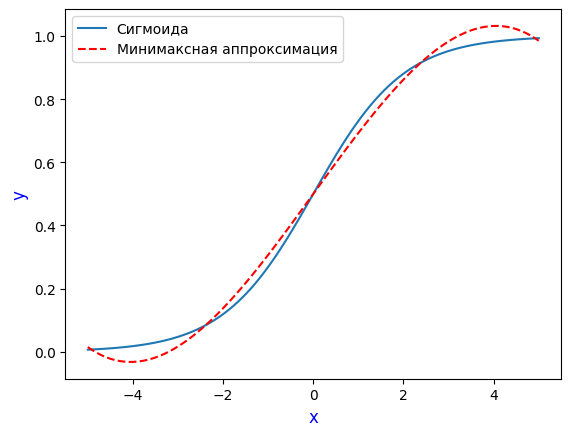

In [13]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def polinom(a, b, c, d, x):
    return a * x ** 3 + b * x ** 2 + c * x + d

x_min, x_max = -5, 5
count = 100

x_list = x_list_minmax = np.linspace(x_min, x_max, count)
y_list = [sigmoid(x) for x in x_list]
y_list_minmax  = [polinom(-0.004, 0, 0.197, 0.5, x) for x in x_list]

plt.plot(x_list, y_list, label='Сигмоида')
plt.plot(x_list_minmax , y_list_minmax, 'r--', label='Минимаксная аппроксимация')
plt.xlabel('x', fontsize=12, color='blue')
plt.ylabel('y', fontsize=12, color='blue')
plt.legend()
plt.show()

С помощью PyTorch, создадим модель логистической регрессии, использующей зашифрованные данные.

In [14]:
class EncryptedLogisticRegression:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # накапливаем градиент и подсчитываем количество итераций
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLogisticRegression.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        # обновляем параметры в соответствии с L2 регуляризацией, приняв α=1 и λ/m=0.05
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # обнуляем накапливание градиента и счётчик итераций
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

Создадим функцию оценивания точности модели, обученной на зашифрованных данных.

In [15]:
def enc_accuracy(model, x_test, y_test):
    w = torch.tensor(model.weight)
    b = torch.tensor(model.bias)
    out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
    correct = torch.abs(y_test - out) < 0.5
    return correct.float().mean()  

Обучим модель логистической регрессии на зашифрованных данных, оценим её точность и сравним с точность модели, обученной на незашифрованных данных.

In [16]:
enc_model = EncryptedLogisticRegression(LogisticRegression(n_features))

times = []
for epoch in range(EPOCHS):
    enc_model.encrypt(ctx_training)
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = enc_model.forward(enc_x)
        enc_model.backward(enc_x, enc_out, enc_y)
    enc_model.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    enc_model.decrypt()
    accuracy = enc_accuracy(enc_model, x_test, y_test)
    print(f"Точность модели за эпоху {epoch + 1}: {accuracy}")


print(f"\nСреднее время обучения модели за эпоху: {int(sum(times) / len(times))} секунд")
print(f"Точность модели обученной на зашифрованных данных {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Разница между точностью модели обученной на зашифрованных и незашифрованных данных: {diff_accuracy}")

Точность модели за эпоху 1: 0.8626560568809509
Точность модели за эпоху 2: 0.8626560568809509
Точность модели за эпоху 3: 0.8626560568809509

Среднее время обучения модели за эпоху: 346 секунд
Точность модели обученной на зашифрованных данных 0.8626560568809509
Разница между точностью модели обученной на зашифрованных и незашифрованных данных: 0.0


Таким образом, были обучены модели логистической регрессии на зашифрованных и на незашифрованных данных, причём обе модели показывают одинаковую точность, однако использование зашифрованных данных решает проблему недостаточной защищённости данных, которые загружаются на облако.